# **Movie Reviews Sentiment Analysis**

# Load necessary libraries

In [2]:
# install modules if working on local machine
!pip install tensorflow
!pip install wordcloud
!pip install nltk

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lisaa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lisaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lisaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lisaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lisaa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Import dataset

# Explore the dataset

The dataset contains 50'000 highly polar movie reviews which are classified as positive or negative.

In [3]:
df = pd.read_csv('C:/Users/lisaa/Downloads/Reviews Dataset.csv')
print('The data shape is:', df.shape)
df.head(5) #preview the first 5 rows

The data shape is: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We can observe the dataset is equally balanced between positive and negative reviews (25'000 each).

In [4]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [5]:
df.groupby(['sentiment'])[['sentiment']].count()

,sentiment
sentiment,
negative,25000
positive,25000


#Add some more features about the dataset

In [7]:
#add word count
def no_of_words(text):
   return len(text.split())

In [8]:
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


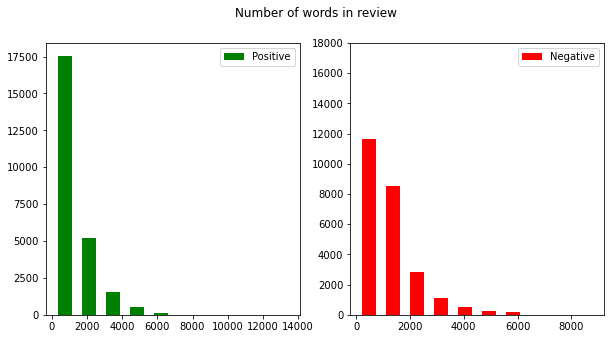

In [9]:
#plot word count
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(df[df['sentiment'] == 'positive']['review'].str.len(), label='Positive', color='green', rwidth=0.6);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['review'].str.len(), label='Negative', color='red', rwidth=0.6);
ax[1].legend(loc='upper right');
ax[1].set_ylim(bottom=0, top=18000),
fig.suptitle("Number of words in review")
plt.show()

In [10]:
#let's add the number of sentence in a review 
def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [11]:
df['sent count'] = df['review'].apply(count_sent)

,review,sentiment,word count,sent count
0,One of the other reviewers has mentioned that ...,positive,307,10
1,A wonderful little production. <br /><br />The...,positive,162,7
2,I thought this was a wonderful way to spend ti...,positive,166,4
3,Basically there's a family where a little boy ...,negative,138,6
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,9


In [12]:
#average sentence lengh
df['avg sentlengh']=df['word count']/df['sent count']

In [14]:
#number of stopwords per review 
def count_stopwords(text):
  stops = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  stopwords_x = [w for w in word_tokens if w in stops]
  return len(stopwords_x)

In [15]:
df['stop count'] = df['review'].apply(count_stopwords)

,review,sentiment,word count,sent count,avg sentlengh,stop count
0,One of the other reviewers has mentioned that ...,positive,307,10,30.700000,128
1,A wonderful little production. <br /><br />The...,positive,162,7,23.142857,65
2,I thought this was a wonderful way to spend ti...,positive,166,4,41.500000,70
3,Basically there's a family where a little boy ...,negative,138,6,23.000000,61
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,9,25.555556,92


In [16]:
#count punctuation 
def count_punctuations(text):
    punctuations='!():;?'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

In [17]:
df['punct_count'] = df["review"].apply(lambda x:count_punctuations(x))

In [18]:
df_punct = pd.DataFrame(list(df.punct_count))
df = pd.merge(df, df_punct, left_index=True, right_index=True)
df.drop(columns=['punct_count'],inplace=True)

,review,sentiment,word count,sent count,avg sentlengh,stop count,! count,( count,) count,: count,; count,? count
0,One of the other reviewers has mentioned that ...,positive,307,10,30.700000,128,0,1,1,0,0,0
1,A wonderful little production. <br /><br />The...,positive,162,7,23.142857,65,1,1,1,1,0,0
2,I thought this was a wonderful way to spend ti...,positive,166,4,41.500000,70,0,2,2,1,0,1
3,Basically there's a family where a little boy ...,negative,138,6,23.000000,61,2,1,1,1,0,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,9,25.555556,92,0,0,0,0,0,0


In [19]:
# Deleting stopwords
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

In [20]:
add_stopwords = ["film", "movie", "character", "br", "one"]
NewStopword = nltk.corpus.stopwords.words('english')
NewStopword.extend(add_stopwords)

In [21]:
def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in set(NewStopword)]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc
df['review'] = df['review'].apply(lambda x: token(x))

In [22]:
#number of positive and negative words per review 
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\lisaa\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [23]:
def count_poswords(text):
  positive_words = set(nltk.corpus.opinion_lexicon.positive())
  word_tokens = word_tokenize(text)
  poswords_x = [w for w in word_tokens if w in positive_words]
  return len(poswords_x)

In [24]:
def count_negwords(text):
  negative_words = set(nltk.corpus.opinion_lexicon.negative())
  word_tokens = word_tokenize(text)
  negwords_x = [w for w in word_tokens if w in negative_words]
  return len(negwords_x)

In [25]:
df['pos count'] = df['review'].apply(count_poswords)

,review,sentiment,word count,sent count,avg sentlengh,stop count,! count,( count,) count,: count,; count,? count,pos count
0,One reviewers mentioned watching 1 Oz episode ...,positive,307,10,30.700000,128,0,1,1,0,0,0,10
1,A wonderful little production . < / > < / > Th...,positive,162,7,23.142857,65,1,1,1,1,0,0,11
2,I thought wonderful way spend time hot summer ...,positive,166,4,41.500000,70,0,2,2,1,0,1,13
3,Basically 's family little boy ( Jake ) thinks...,negative,138,6,23.000000,61,2,1,1,1,0,0,2
4,Petter Mattei 's `` Love Time Money '' visuall...,positive,230,9,25.555556,92,0,0,0,0,0,0,13


In [26]:
df['neg count'] = df['review'].apply(count_negwords)

,review,sentiment,word count,sent count,avg sentlengh,stop count,! count,( count,) count,: count,; count,? count,pos count,neg count
0,One reviewers mentioned watching 1 Oz episode ...,positive,307,10,30.700000,128,0,1,1,0,0,0,10,18
1,A wonderful little production . < / > < / > Th...,positive,162,7,23.142857,65,1,1,1,1,0,0,11,1
2,I thought wonderful way spend time hot summer ...,positive,166,4,41.500000,70,0,2,2,1,0,1,13,4
3,Basically 's family little boy ( Jake ) thinks...,negative,138,6,23.000000,61,2,1,1,1,0,0,2,7
4,Petter Mattei 's `` Love Time Money '' visuall...,positive,230,9,25.555556,92,0,0,0,0,0,0,13,2


In [27]:
#average pos and neg words
df['avg posword']=df['pos count']/df['word count']
df['avg negword']=df['neg count']/df['word count']

Let's have a look at one review

In [29]:
df['review'].loc[0]

"One reviewers mentioned watching 1 Oz episode 'll hooked . They right , exactly happened me. < / > < / > The first thing struck Oz brutality unflinching scenes violence , set right word GO . Trust , show faint hearted timid . This show pulls punches regards drugs , sex violence . Its hardcore , classic use word. < / > < / > It called OZ nickname given Oswald Maximum Security State Penitentary . It focuses mainly Emerald City , experimental section prison cells glass fronts face inwards , privacy high agenda . Em City home many .. Aryans , Muslims , gangstas , Latinos , Christians , Italians , Irish .... scuffles , death stares , dodgy dealings shady agreements never far away. < / > < / > I would say main appeal show due fact goes shows would n't dare . Forget pretty pictures painted mainstream audiences , forget charm , forget romance ... OZ n't mess around . The first episode I ever saw struck nasty surreal , I could n't say I ready , I watched , I developed taste Oz , got accustomed

Let's visualize the most used words for each type of sentiment using word cloud

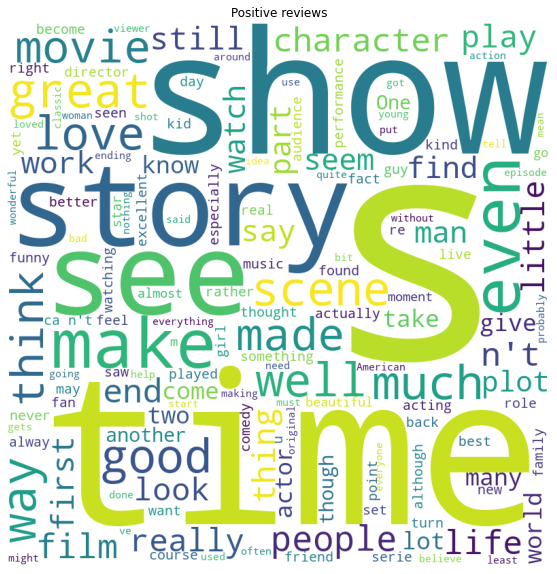

In [30]:
# Most used words in positive reviews (Stopwords already gone)

text_review = df ['review']

pos=' '.join(map(str,text_review[df['sentiment']=='positive']))

wordcloud_pos = WordCloud(width = 800, height = 800,
                background_color ='white', 
                min_font_size = 12).generate(pos) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_pos)
plt.title('Positive reviews')
plt.axis('off')
plt.show() 

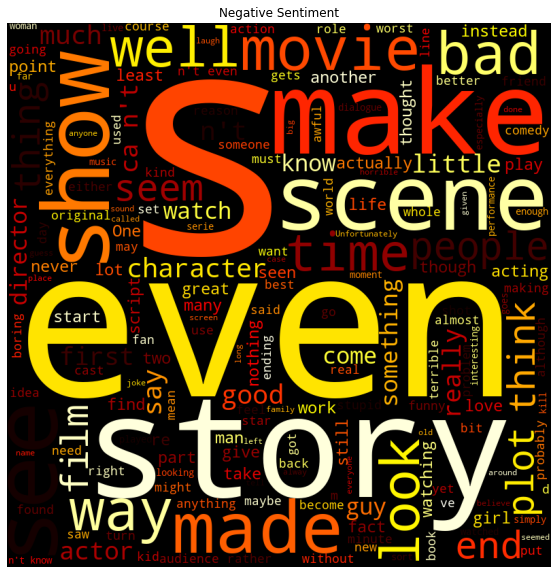

In [31]:
# Most used words in negative reviews

neg=' '.join(map(str,text_review[df['sentiment']=='negative']))

wordcloud_neg = WordCloud(width = 800, height = 800, 
                colormap = 'hot',
                background_color ='black', 
                min_font_size = 12).generate(neg) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_neg)
plt.title('Negative Sentiment')
plt.axis('off')
plt.show() 

We can see that the most used words contain some html tags ('br'). Also, words like 'film' or 'movie' are very frequent but don't tell much about the sentiment. We will do some cleaning during the data preprocessing.


# Data Preprocessing

**Remove punctuation, special caracters, uppercase and extra spaces**


In [32]:
df['review'] = df['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
df['review'] = df['review'].apply(lambda x: x.lower())                      #lowercase
df['review'] = df['review'].apply(lambda x: x.strip())                      #clear extra spaces

In [33]:
# df['review'].loc[0]  #uncomment to have a look at a review after this first cleaning

**Apply lemmatization**

In [34]:
# Lemmatization (= stripping the word to its root form, eg. 'working', 'worker', 'works' are transformed into 'work'
lemmatizer = WordNetLemmatizer()

def lemmatize_it(sent):
    empty = []
    for word, tag in pos_tag(word_tokenize(sent)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
            empty.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(word, wntag)
            empty.append(lemma)
    return ' '.join(empty)

In [35]:
df['review'] = df['review'].apply(lemmatize_it) # takes about 7 min to run

**Check cleaned data**

In [36]:
#Let's have a look at a review after the data cleaning
df['review'].loc[0]

'one reviewer mention watch oz episode ll hook they right exactly happen me the first thing strike oz brutality unflinching scene violence set right word go trust show faint hearted timid this show pull punch regard drug sex violence its hardcore classic use word it call oz nickname give oswald maximum security state penitentary it focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangstas latinos christian italian irish scuffle death stare dodgy dealing shady agreement never far away i would say main appeal show due fact go show would n t dare forget pretty picture paint mainstream audience forget charm forget romance oz n t mess around the first episode i ever saw struck nasty surreal i could n t say i ready i watch i develop taste oz get accustomed high level graphic violence not violence injustice crook guard ll sell nickel inmates ll kill order get away well mannered middle class inmate turn priso

In [38]:
# Convert sentiment into numerical value (1 = positive, 0 = negative)
df.sentiment.replace("positive", 1, inplace=True)
df.sentiment.replace("negative", 0, inplace=True)

# Model: Prepare train and test sets 

In [87]:
df.columns

Index(['review', 'sentiment', 'word count', 'sent count', 'avg sentlengh',
       'stop count', '! count', '( count', ') count', ': count', '; count',
       '? count', 'pos count', 'neg count', 'avg posword', 'avg negword'],
      dtype='object')

In [222]:
Y_t = df['sentiment']
X_t = df[['word count', 'sent count', 'avg sentlengh', 'stop count', '! count', '( count', ') count', ': count', '; count', '? count', 'pos count', 'neg count', 'avg posword', 'avg negword']]

In [218]:
X_t.head()

,word count,sent count,avg sentlengh,stop count,! count,( count,) count,: count,; count,? count,pos count,neg count,avg posword,avg negword
0,188,10,30.700000,128,0,1,1,0,0,0,10,18,0.032573,0.058632
1,94,7,23.142857,65,1,1,1,1,0,0,11,1,0.067901,0.006173
2,96,4,41.500000,70,0,2,2,1,0,1,13,4,0.078313,0.024096
3,67,6,23.000000,61,2,1,1,1,0,0,2,7,0.014493,0.050725
4,127,9,25.555556,92,0,0,0,0,0,0,13,2,0.056522,0.008696


In [223]:
X = X_t.to_numpy()

In [221]:
X

array([[1.88000000e+02, 1.00000000e+01, 3.07000000e+01, ...,
        1.80000000e+01, 3.25732899e-02, 5.86319218e-02],
       [9.40000000e+01, 7.00000000e+00, 2.31428571e+01, ...,
        1.00000000e+00, 6.79012346e-02, 6.17283951e-03],
       [9.60000000e+01, 4.00000000e+00, 4.15000000e+01, ...,
        4.00000000e+00, 7.83132530e-02, 2.40963855e-02],
       ...,
       [1.30000000e+02, 6.00000000e+00, 3.83333333e+01, ...,
        1.30000000e+01, 3.04347826e-02, 5.65217391e-02],
       [1.16000000e+02, 8.00000000e+00, 2.65000000e+01, ...,
        1.30000000e+01, 3.30188679e-02, 6.13207547e-02],
       [6.40000000e+01, 3.00000000e+00, 4.30000000e+01, ...,
        4.00000000e+00, 4.65116279e-02, 3.10077519e-02]])

In [225]:
Y_t

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [226]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y_t, test_size=0.2, random_state=42)

In [227]:
x_train.shape

(40000, 14)

# Build the models

In [288]:
model = Sequential()

model.add(Dense(units=8, activation='softmax', input_shape=(14,))) #input layer
model.add(Dense(units=1, activation='sigmoid')) #output layer

optimizer =tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #optimizer: Adam or rmsprop

In [291]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 8)                 120       
                                                                 
 dense_61 (Dense)            (None, 1)                 9         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


# Fit the models

In [289]:
hist = model.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
400/400 [==============================] - 1s 1ms/step - loss: 0.7210 - accuracy: 0.5010 - val_loss: 0.6947 - val_accuracy: 0.4961
Epoch 2/15
400/400 [==============================] - 0s 880us/step - loss: 0.6363 - accuracy: 0.6244 - val_loss: 0.5894 - val_accuracy: 0.7273
Epoch 3/15
400/400 [==============================] - 0s 904us/step - loss: 0.5795 - accuracy: 0.7286 - val_loss: 0.5688 - val_accuracy: 0.7348
Epoch 4/15
400/400 [==============================] - 0s 881us/step - loss: 0.5662 - accuracy: 0.7333 - val_loss: 0.5592 - val_accuracy: 0.7378
Epoch 5/15
400/400 [==============================] - 0s 903us/step - loss: 0.5587 - accuracy: 0.7355 - val_loss: 0.5540 - val_accuracy: 0.7405
Epoch 6/15
400/400 [==============================] - 0s 902us/step - loss: 0.5545 - accuracy: 0.7361 - val_loss: 0.5507 - val_accuracy: 0.7394
Epoch 7/15
400/400 [==============================] - 0s 911us/step - loss: 0.5516 - accuracy: 0.7365 - val_loss: 0.5490 - val_accuracy: 0

# Evaluate model

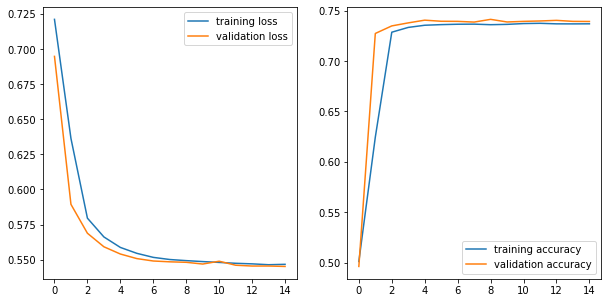

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

## Feature Importance

In [246]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [247]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=150)

Text(0.5, 0, 'Feature Importance')

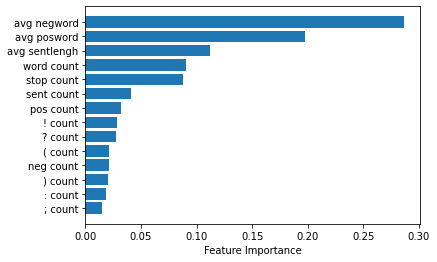

In [256]:
sort = rf.feature_importances_.argsort()
plt.barh(X_t.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")